# MODEL TRAINER


In [3]:
#Importing basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#Modelling
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

## Reading the source dataset as a Pandas Dataframe


In [4]:
df=pd.read_csv('StudentsPerformance.csv')


In [7]:
#Top 5 Records
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_score
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229


In [6]:
df['total_score']=df['math score']+df['reading score']+df['writing score']

# Preparing to predict total score based on all independent features
## Preparing X and y variables

In [18]:
X=df.drop(columns=['total_score'],axis=1)

In [20]:
X

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [10]:
y=df['total_score']

In [12]:
y.

0    218
1    247
2    278
3    148
4    229
Name: total_score, dtype: int64

In [21]:
#Column Transformer pipeline for simultaneous transformation

numerical_features=X.select_dtypes(exclude="object").columns
categorical_features=X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transfomer=StandardScaler()
ohe_transformer=OneHotEncoder()

preprocessor=ColumnTransformer(
    [
        ("OneHotEncoder", ohe_transformer,categorical_features),
        ("StandardScaler", numeric_transfomer,numerical_features),
    ]
)

In [23]:
X=preprocessor.fit_transform(X)

In [24]:
X

array([[ 1.        ,  0.        ,  0.        , ...,  0.39002351,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.19207553,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.57771141,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.46775108,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.12609287,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  0.71993682,
         1.15336989,  1.18158627]])

In [25]:
X.shape

(1000, 20)

In [35]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
X_train

array([[ 1.        ,  0.        ,  0.        , ..., -0.2698031 ,
         0.05694554,  0.45733301],
       [ 1.        ,  0.        ,  0.        , ..., -0.00587246,
         0.94779033,  0.98406266],
       [ 1.        ,  0.        ,  0.        , ...,  0.85190214,
         1.35894946,  1.18158627],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.86364705,
        -0.49126664, -0.99117351],
       [ 0.        ,  1.        ,  0.        , ..., -1.06159503,
        -1.45063795, -0.99117351],
       [ 1.        ,  0.        ,  0.        , ...,  1.2477981 ,
         1.4960025 ,  1.37910989]])

In [37]:
y_test

521    261
737    192
740    225
660    224
411    245
      ... 
408    165
332    171
208    231
613    216
78     207
Name: total_score, Length: 200, dtype: int64

In [38]:
X_train.shape, X_test.shape

((800, 20), (200, 20))

In [48]:
def evaluate_model(y_true, y_pred):
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Return metrics as a dictionary
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

    

In [63]:
models={
    "Linear Regression":LinearRegression(),
    "Ridge":Ridge(),
    "Lasso":Lasso(),
    "Decision Tree":DecisionTreeRegressor(),
    "K-Nearest Neighbors":KNeighborsRegressor(),
    "Random-Forest":RandomForestRegressor(),
    "CatBoost":CatBoostRegressor(verbose=False),
    "XGBoost":XGBRegressor(),
    "AdaBoost":AdaBoostRegressor()
}
model_list=[]
r2_list=[]
for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Model predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluation of test and train
    model_train_metrics = evaluate_model(y_train, y_train_pred)
    model_test_metrics = evaluate_model(y_test, y_test_pred)

    print(model_name)
    model_list.append(model_name)

    print("Model Performance for Training Dataset")
    print("- Root Mean Squared Error: {:.4f}".format(model_train_metrics['rmse']))
    print("- Mean Absolute Error: {:.4f}".format(model_train_metrics['mae']))
    print("- r2 Score: {:.4f}".format(model_train_metrics['r2']))
          
    print("-----------------------------------------------------")
    print("Model Performance for Test Dataset")
    print("- Root Mean Squared Error: {:.4f}".format(model_test_metrics['rmse']))
    print("- Mean Absolute Error: {:.4f}".format(model_test_metrics['mae']))
    print("- r2 Score: {:.4f}".format(model_test_metrics['r2']))

    r2_list.append(model_test_metrics['r2'])

    print("=" * 35)
    print("\n")


Linear Regression
Model Performance for Training Dataset
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- r2 Score: 1.0000
-----------------------------------------------------
Model Performance for Test Dataset
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- r2 Score: 1.0000


Ridge
Model Performance for Training Dataset
- Root Mean Squared Error: 0.0241
- Mean Absolute Error: 0.0195
- r2 Score: 1.0000
-----------------------------------------------------
Model Performance for Test Dataset
- Root Mean Squared Error: 0.0264
- Mean Absolute Error: 0.0201
- r2 Score: 1.0000


Lasso
Model Performance for Training Dataset
- Root Mean Squared Error: 1.0644
- Mean Absolute Error: 0.8505
- r2 Score: 0.9994
-----------------------------------------------------
Model Performance for Test Dataset
- Root Mean Squared Error: 1.1139
- Mean Absolute Error: 0.8764
- r2 Score: 0.9994


Decision Tree
Model Performance for Training Dataset
- Root Mean Squared Error: 0.

In [64]:
pd.DataFrame(list(zip(model_list,r2_list)),columns=['model_name','r2']).sort_values(by='r2', ascending=False)

,model_name,r2
0,Linear Regression,1.000000
1,Ridge,1.000000
2,Lasso,0.999357
7,XGBoost,0.994759
5,Random-Forest,0.993583
6,CatBoost,0.993457
3,Decision Tree,0.987524
8,AdaBoost,0.980035
4,K-Nearest Neighbors,0.956016


## Moving Forward with Linear Regression



In [68]:
adaboost_model=AdaBoostRegressor()
adaboost_model=adaboost_model.fit(X_train,y_train)
y_pred=adaboost_model.predict(X_test)
score=r2_score(y_test,y_pred)*100
print("Accuracy of the model %.2f" %score)


Accuracy of the model 97.90


## Plot y-test and y-pred

Text(0, 0.5, 'Predicted')

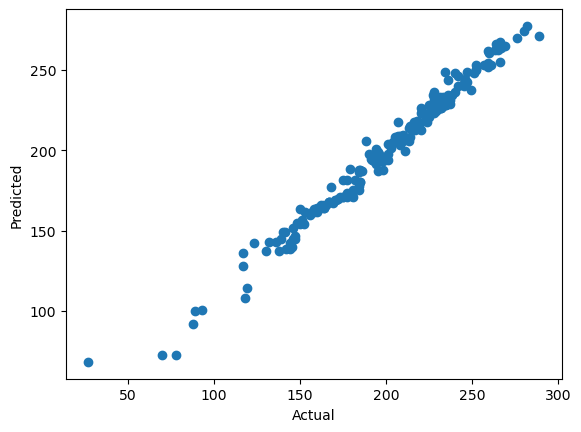

In [69]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='total_score'>

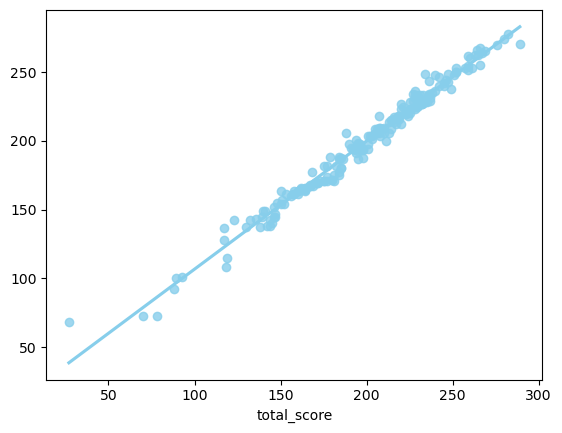

In [71]:
import seaborn as sns
sns.regplot(x=y_test,y=y_pred,ci=None,color="skyblue")

## Difference between Acutal and Predicted Values


In [73]:
pred_df=pd.DataFrame({'Actual values':y_test, 'Predicted Values':y_pred, 'Difference':y_test-y_pred})
pred_df

,Actual values,Predicted Values,Difference
521,261,253.159664,7.840336
737,192,194.235602,-2.235602
740,225,222.892857,2.107143
660,224,220.426540,3.573460
411,245,242.016393,2.983607
...,...,...,...
408,165,166.040462,-1.040462
332,171,169.156250,1.843750
208,231,230.325581,0.674419
613,216,217.648810,-1.648810
